## Imports

In [1]:
import ast
import math
import requests
import urllib
import time
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from ast import literal_eval
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

Definitions of constants

In [2]:
PROCESSED_DATA_FOLDER = '../processed_data/'
CORENLP_DATA_FOLDER   = '../corenlp_plot_summaries/'

PROCESSED_CHARACTER   = PROCESSED_DATA_FOLDER + 'character_metadata.csv'
PROCESSED_MOVIE       = PROCESSED_DATA_FOLDER + 'movie_metadata.csv'
PROCESSED_NAME        = PROCESSED_DATA_FOLDER + 'name_clusters.csv'
PROCESSED_PLOT        = PROCESSED_DATA_FOLDER + 'plot_summaries.csv'
PROCESSED_TVTROPES    = PROCESSED_DATA_FOLDER + 'tvtropes_clusters.csv'
PROCESSED_LIFE_EXP    = PROCESSED_DATA_FOLDER + 'life_expectancy.csv'

Load the cleaned data

In [3]:
character_metadata = pd.read_csv(PROCESSED_CHARACTER)
movie_metadata     = pd.read_csv(PROCESSED_MOVIE)
plot_summaries     = pd.read_csv(PROCESSED_PLOT)
name_clusters      = pd.read_csv(PROCESSED_NAME)
tvtropes_cluster   = pd.read_csv(PROCESSED_TVTROPES)
life_expectancy_df = pd.read_csv(PROCESSED_LIFE_EXP)

### 1.2 Creating the datasets

The movie gender dataframe with values about the ratio women / men

In [4]:
movie_gender = character_metadata.groupby(['wikipedia_movie_id', 'actor_gender']).size().unstack(fill_value=0)
movie_gender['number_actors'] = movie_gender['F'] + movie_gender['M']

# ratio women / total actors
movie_gender['women_ratio'] = movie_gender['F'] / movie_gender['number_actors']

# difference male - women
movie_gender['sex_diff'] = movie_gender['M'] - movie_gender['F']

movie_gender = movie_gender[['women_ratio', 'number_actors', 'sex_diff']].reset_index()

Gender parity datasets

In [5]:
movie_information = ['wikipedia_movie_id', 'movie_release_year', 'movie_name', 'office_revenue', 'countries', 'genres']
gender_parity = pd.merge(movie_gender, movie_metadata[movie_information], on='wikipedia_movie_id').dropna()

Movie genre dataset

In [6]:
movie_genre_information = ['wikipedia_movie_id', 'movie_release_date', 'movie_name','genres']

movie_genre = pd.merge(movie_metadata[movie_genre_information].rename(columns={'wikipedia_movie_id' : 'movie_id'}), \
    plot_summaries, on='movie_id', how='inner').dropna()

#we are interested in the year only
movie_genre['year'] = pd.DatetimeIndex(movie_genre['movie_release_date']).year.astype('int')
movie_genre = movie_genre.drop(columns=['movie_release_date'])

#we convert the values of the genres dictionnaries to list
movie_genre['genres'] = movie_genre['genres'].apply(ast.literal_eval).apply(lambda x : set(x.values()))

### Useful Functions

In [19]:
def bootstrap_ci(data, weights=None, ci=0.95):
    if weights != None:
        data = np.repeat(data, weights)
    if len(set(data)) > 1 :
        bootstrap_res = stats.bootstrap((data,), np.mean, confidence_level=ci, n_resamples=500)
        return bootstrap_res.confidence_interval
    else :
        return np.nan

In [20]:
def deconstruct_dict(df, col_name):
    df[col_name] = df[col_name] \
        .apply(ast.literal_eval).apply(lambda x : list(x.values()))
    df = df.apply(pd.Series.explode)\
        .reset_index().drop(columns=['index'])
    return df

In [21]:
def make_subset_gender_parity(col_name, gender_parity_df = gender_parity) :
    subset = gender_parity_df[['women_ratio','wikipedia_movie_id', col_name]].copy()

    #change the dict to list of values and explode them to get one value per row
    subset = deconstruct_dict(subset, col_name)

    #group by the desired column and make the mean of the women ratios
    subset = subset.groupby(col_name)\
        .agg({'women_ratio' : ['mean', bootstrap_ci], 'wikipedia_movie_id' : 'count'})\
        .sort_values(by=[('women_ratio', 'mean')])

    subset.columns = ['_'.join(col) for col in subset.columns.values]

    return subset.reset_index()

### Functions for A and B

In [22]:
def test_overlap(before_ci, after_ci):
    cond1 = before_ci[0] < after_ci[0]  < before_ci[1]
    cond2 = before_ci[0] < after_ci[1]  < before_ci[1]
    cond3 = after_ci[0]  < before_ci[1] < after_ci[1]
    cond4 = after_ci[0]  < before_ci[1] < after_ci[1]
    return cond1 or cond2 or cond3 or cond4

In [23]:
def split_gender_parity(treshold_year):
    before = gender_parity[gender_parity.movie_release_year <= treshold_year]
    after  = gender_parity[gender_parity.movie_release_year >  treshold_year]
    return before, after

In [24]:
def split_and_filter(treshold_year, min_count, col_name):
    gender_parity_before, gender_parity_after = split_gender_parity(treshold_year)

    before = make_subset_gender_parity(col_name, gender_parity_before)
    after  = make_subset_gender_parity(col_name, gender_parity_after )

    merged = before.merge(after, on=col_name, suffixes=('_before', '_after'))

    merged_filtered = merged[merged.wikipedia_movie_id_count_after + merged.wikipedia_movie_id_count_before > min_count]

    return merged_filtered

In [25]:
average_ratio = np.average(gender_parity['women_ratio'])

In [26]:
def plot_ratio_by_categories(subset, col_name, min_count=100):
    filtered_subset = subset[subset.wikipedia_movie_id_count > min_count].dropna()

    plt.figure(figsize=(6, len(filtered_subset) * 0.2))
    for i, col in enumerate(filtered_subset[['women_ratio_mean', 'women_ratio_bootstrap_ci']].iloc):
        plt.plot(col['women_ratio_bootstrap_ci'], (i,i),'-|k')
        plt.plot(col['women_ratio_mean'], i, '.r')

    plt.yticks(range(len(filtered_subset)),list(filtered_subset[col_name]))
    plt.vlines(average_ratio, 0, len(filtered_subset), linestyle = '--')

    plt.title('Ratio of women by ' + col_name + ' with 95% confidence intervals')
    plt.ylabel(col_name)
    plt.xlabel('Ratio of women')

In [27]:
def plot_evolution(col_name, treshold_year, min_count=100):
    merged_filtered = split_and_filter(treshold_year, min_count, col_name).dropna()

    plt.figure(figsize=(6, len(merged_filtered) * 0.2))

    for y, col in enumerate(merged_filtered.iloc):
        plt.plot(col['women_ratio_bootstrap_ci_before'], (y,y),'-|b')
        plt.plot(col['women_ratio_mean_before'], y, '.b')
        plt.plot(col['women_ratio_bootstrap_ci_after'], (y,y),'-|g')
        plt.plot(col['women_ratio_mean_after'], y, '.b')

    plt.yticks(range(len(merged_filtered)),list(merged_filtered[col_name]))
    plt.vlines(average_ratio, 0, len(merged_filtered), linestyle = '--')

    plt.title('evolution (before/after ' + str(treshold_year) + ' ) of ratio by ' + col_name + ' with 95% confidence intervals')
    plt.ylabel(col_name)
    plt.xlabel('Ratio of women')

In [28]:
def plot_evolution_arrow(col_name, treshold_year, min_count=100):
    merged_filtered = split_and_filter(treshold_year, min_count, col_name).dropna()

    plt.figure(figsize=(6, len(merged_filtered) * 0.2))

    for y, col in enumerate(merged_filtered.iloc):
        ratio_before = col['women_ratio_mean_before']
        ratio_after  = col['women_ratio_mean_after' ]
        dx = ratio_after - ratio_before
        plt.plot(col['women_ratio_mean_before'], y, '.r')
        overlap = test_overlap(col['women_ratio_bootstrap_ci_before'], col['women_ratio_bootstrap_ci_after'])
        plt.arrow(ratio_before, y, dx, 0,
                  head_width = 0.7,
                  head_length = 0.005,
                  ec = 'black' if overlap else 'red')

    plt.yticks(range(len(merged_filtered)),list(merged_filtered[col_name]))
    plt.vlines(average_ratio, 0, len(merged_filtered), linestyle = '--')

    plt.title('evolution (before/after ' + str(treshold_year) + ' ) of ratio by ' + col_name + ' as arrows')
    plt.ylabel(col_name)
    plt.xlabel('Ratio of women')

In [29]:
def plot_by_year(col_name, attribute):
    df = deconstruct_dict(gender_parity.copy(), col_name)
    df[df[col_name] == attribute][['movie_release_year', 'women_ratio']].groupby('movie_release_year').agg('mean').plot()
    plt.title('ratio by year in ' + attribute)
    plt.ylabel('ratio')
    plt.xlabel('year')

### A. What is the gender parity across movie genres (are westerns still as male dominated as the stereotype describes it?)

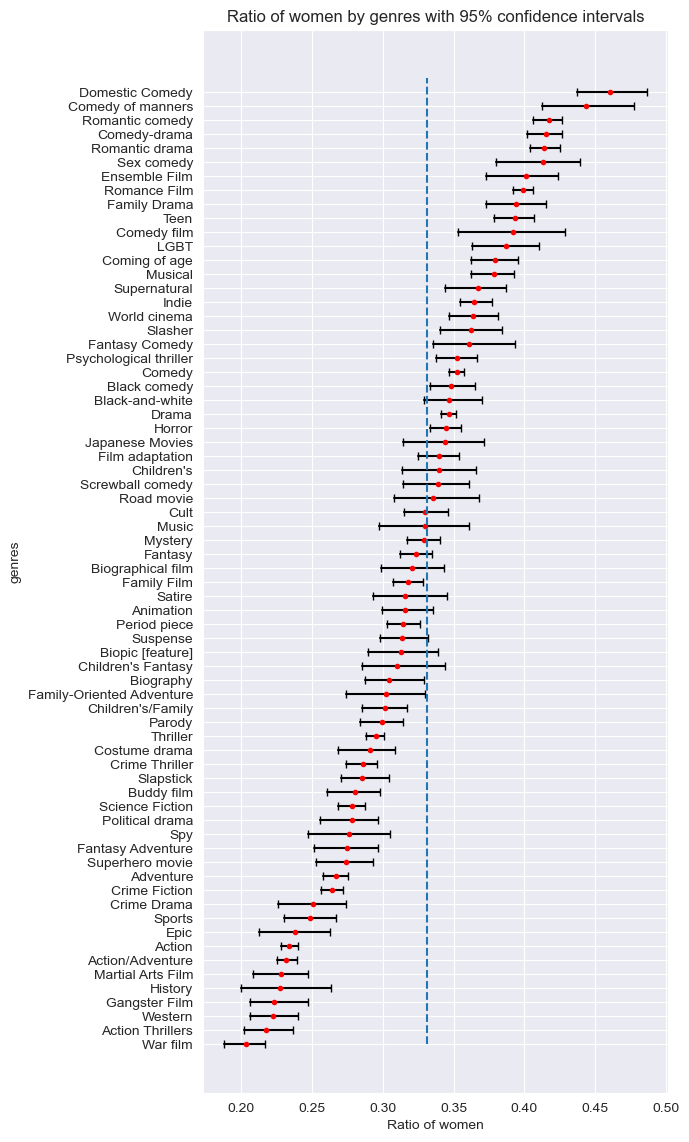

In [30]:
movie_gender_genre = make_subset_gender_parity('genres')
plot_ratio_by_categories(movie_gender_genre, 'genres', min_count=100)

Above we can clearly see that movie genre is significantly impacting gender ratio.
Indeed, average ratio is out of confident intervals for many movies genres.

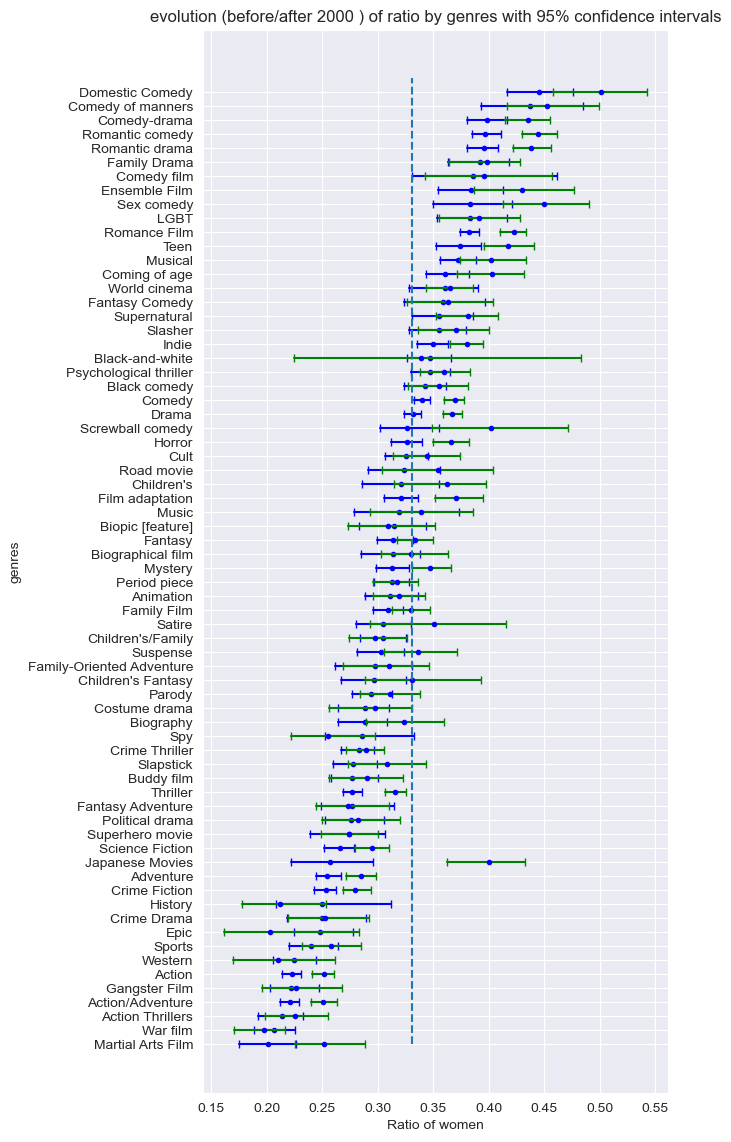

In [31]:
plot_evolution('genres', 2000, min_count=100)

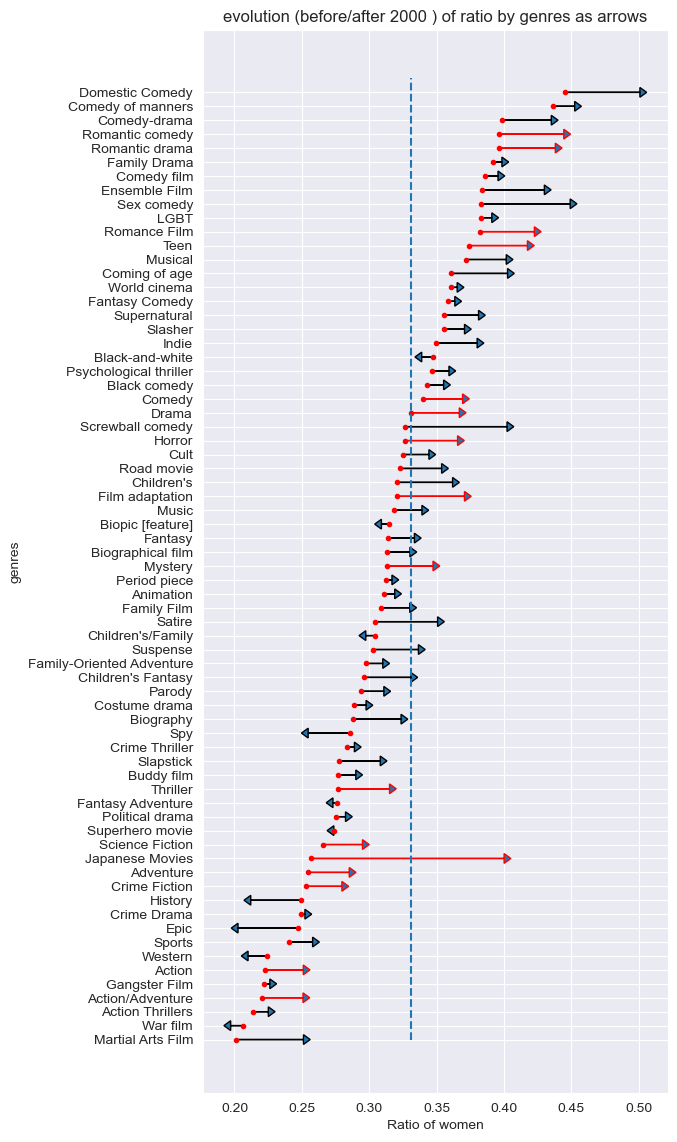

In [32]:
plot_evolution_arrow('genres', 2000, min_count=100)

Above we can see the evolution showed by arrows. Only red arrows show evolution statistically significant under $\alpha = 0.05$

### B. what is the evolution of gender parity in films among countries over time (were some countries avant-garde? Are some still behind on this concept?)

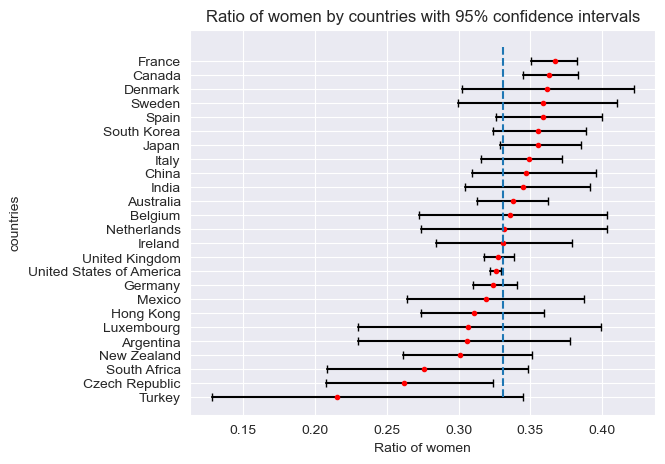

In [149]:
movie_gender_country = make_subset_gender_parity('countries')
plot_ratio_by_categories(movie_gender_country, 'countries', min_count=20)

Above we cannot observe significant impact of country on the gender ratio.
Indeed, average ratio is inside of confident intervals for many countries.

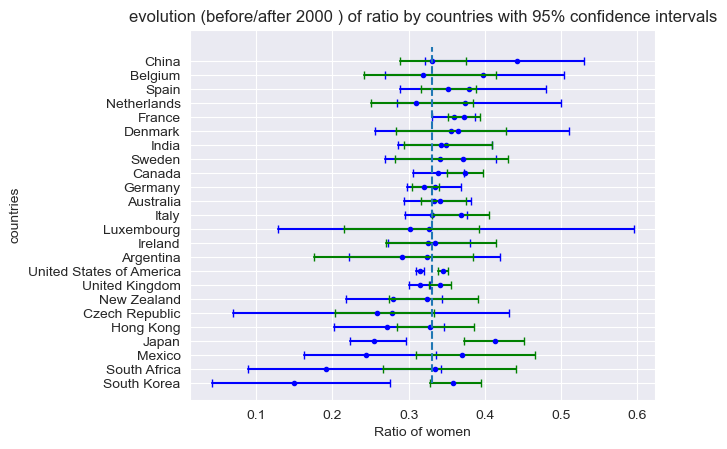

In [150]:
plot_evolution('countries', 2000, min_count=20)

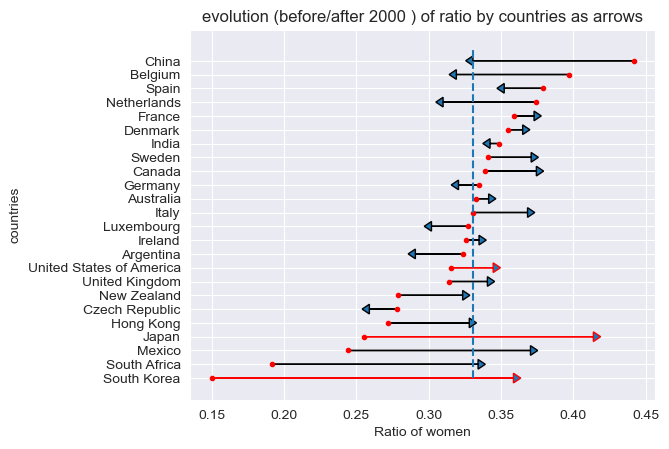

In [151]:
plot_evolution_arrow('countries', 2000, min_count=20)

Above we can see the evolution showed by arrows. Only red arrows show evolution statistically significant under $\alpha = 0.05$

Let's now analyze to a more world view.

In [36]:
movie_gender_country = movie_gender_country.drop(columns=['women_ratio_bootstrap_ci'])

#get the world countries
world_countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [37]:
def plot_world(title : str) :
    # initialize an axis
    fig, ax = plt.subplots(figsize=(8,6))
    plt.title(title)

    #plot the countries in light gray
    world_countries.plot(color="k", alpha=0.1, ax=ax)
    return ax

In [38]:
def plot_ratio_country() :
    ax = plot_world("World heatmap of the women ratio by country")

    #add the color in function of the women ratio
    df = world_countries.merge(movie_gender_country.loc[movie_gender_country['wikipedia_movie_id_count'] >= 2] \
                     .rename(columns={'countries' : 'name'}), on='name', how='inner')

    return gpd.GeoDataFrame(df).plot(column='women_ratio_mean',ax=ax, legend=True)

In [39]:
def plot_ratio_continent() :
    ax = plot_world("World heatmap of the women ratio by continent")

    #add the color in function of the women ratio
    df = world_countries.merge(movie_gender_country.loc[movie_gender_country['wikipedia_movie_id_count'] > 2]
                        .rename(columns={'countries' : 'name'}), on='name', how='inner')

    continent = df[['continent', 'women_ratio_mean']].groupby('continent').mean().reset_index().rename(columns={'women_ratio_mean' : 'continent_women_ratio'})
    df = world_countries.merge(continent,on='continent')

    return gpd.GeoDataFrame(df).plot(column='continent_women_ratio',ax=ax, legend=True)

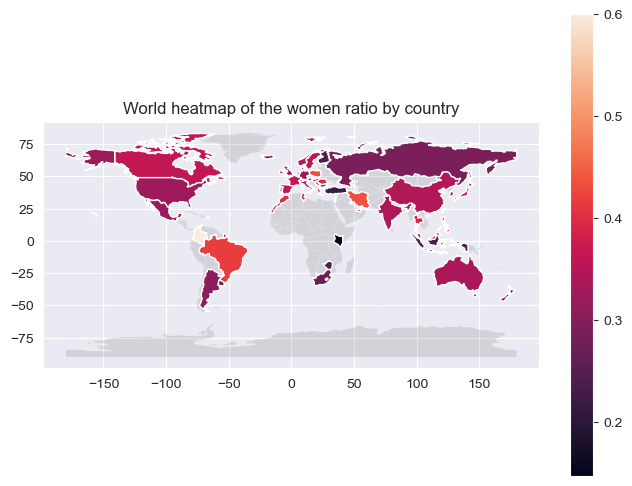

In [40]:
plot_ratio_country() ;

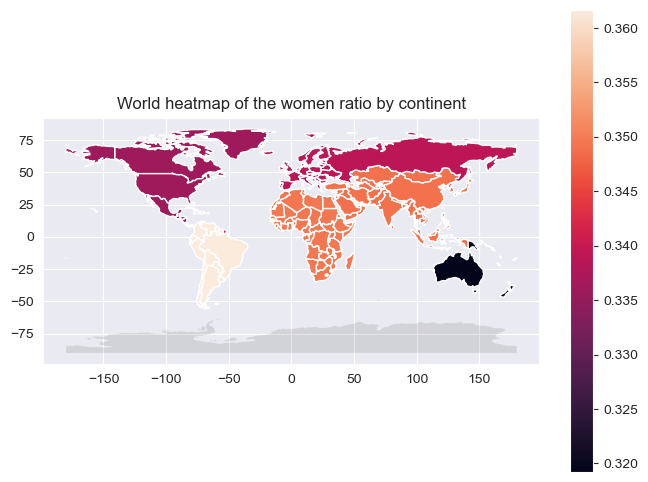

In [41]:
plot_ratio_continent() ;

### C. Is there a variation in the box office revenue depending on the gender parity? Has it change over the years?

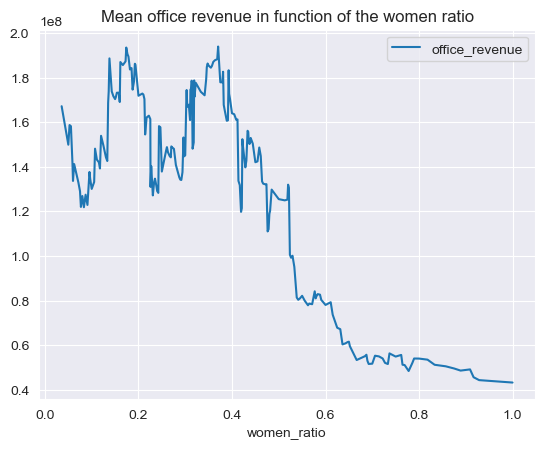

In [42]:
movie_gender_office_revenue = gender_parity[['women_ratio','office_revenue']].\
    groupby('women_ratio')\
    .agg({'office_revenue' : 'mean'})

#make a mean by rolling windows to smooth up the function
movie_gender_office_revenue = movie_gender_office_revenue.rolling(window=30, min_periods=1, center=False).mean()
movie_gender_office_revenue = movie_gender_office_revenue.iloc[2:].reset_index()

#now we can plot a graph
movie_gender_office_revenue.plot(x='women_ratio', y='office_revenue', title="Mean office revenue in function of the women ratio") ;


Yes it appeared that the women_ratio does influence the mean office revenue of a film. But is it the only factor ? Are there more influencial factors ? For that we are going to do a linear regression with multiple factors.

In [43]:
def create_gender_df() :
    df = gender_parity.copy()
    df = deconstruct_dict(df, 'countries')
    df = deconstruct_dict(df, 'genres')
    df = df[['women_ratio', 'number_actors', 'movie_release_year', 'office_revenue', 'countries', 'genres', 'sex_diff']]

    # scale attributes in range [0,1] to have insightful regression
    attributes_to_scale = ['women_ratio', 'number_actors', 'movie_release_year','sex_diff']
    scaler = MinMaxScaler()
    df[attributes_to_scale] = scaler.fit_transform(df[attributes_to_scale])
    return df

Make linear regression

In [44]:
mod = smf.ols(formula='np.log(office_revenue) ~ women_ratio + movie_release_year + \
    number_actors + C(genres) + C(countries)', data=create_gender_df())

#adding a random seed ensures consistency
np.random.seed(42)
res = mod.fit()

print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(office_revenue)   R-squared:                       0.276
Model:                                OLS   Adj. R-squared:                  0.271
Method:                     Least Squares   F-statistic:                     54.95
Date:                    Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                            15:14:55   Log-Likelihood:            -1.1721e+05
No. Observations:                   57837   AIC:                         2.352e+05
Df Residuals:                       57438   BIC:                         2.388e+05
Df Model:                             398                                         
Covariance Type:                nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [45]:
print("The most influencial factors of the linear regression with p-values :")
print(res.pvalues.sort_values()[:5])

The most influencial factors of the linear regression with p-values :
number_actors               0.000000e+00
movie_release_year         5.628735e-231
Intercept                   7.030133e-93
women_ratio                 3.131965e-18
C(genres)[T.Gay Themed]     2.468621e-14
dtype: float64


In [46]:
print("The coefficient for the women ratio factor = {:.4}".format(res.params.women_ratio))

The coefficient for the women ratio factor = -0.4253


After isolating the different factors, we can see that the `women_ratio` has a p_valued $<< \alpha$ so it does indeed negatively influence (negative coefficient) the office revenue of the movies.

### D. Is there a variation of the main attributes -agent verbs, patient verbs and attributes- given to each gender across time?

In [72]:
movie_nlp = pd.read_csv(PROCESSED_DATA_FOLDER + 'movie_nlp.csv', index_col='movie_id', dtype={'movie_id' : int},
                            converters={'actions by men'      : literal_eval, 'actions by women'      : literal_eval,
                                        'actions on men'      : literal_eval, 'actions on women'      : literal_eval,
                                        'descriptions of men' : literal_eval, 'descriptions of women' : literal_eval})

In [73]:
nlp_descriptions = ['actions by men', 'actions by women', 'actions on men', 'actions on women', 'descriptions of men', 'descriptions of women']
nlp_number_descriptions = ['number of ' + d for d in nlp_descriptions]
actions = ['actions by men', 'actions by women', 'actions on men', 'actions on women']

In [74]:
for i in range(6):
    movie_nlp[nlp_number_descriptions[i]] = movie_nlp[nlp_descriptions[i]].apply(len)

In [75]:
for desc in nlp_descriptions:
    movie_nlp[desc + ' unique'] = movie_nlp[desc].apply(np.unique)

In [76]:
movie_metadata_nlp = movie_metadata[['wikipedia_movie_id', 'movie_release_year']].dropna()\
    .merge(movie_nlp, left_on='wikipedia_movie_id', right_on='movie_id')

In [77]:
movie_metadata_nlp['decade_released'] = movie_metadata_nlp['movie_release_year'].apply(lambda year : math.floor(year/10) * 10)

In [78]:
movie_metadata_nlp = movie_metadata_nlp.set_index('wikipedia_movie_id')

#### Plotting results

In [138]:
res = pd.DataFrame(movie_metadata_nlp[['decade_released'] + nlp_number_descriptions].groupby('decade_released').agg([np.sum]))

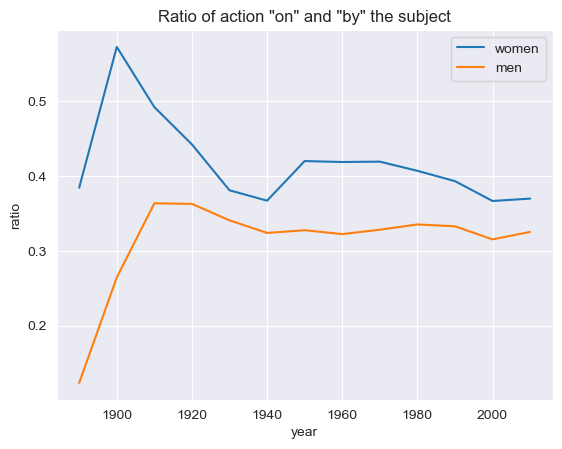

In [139]:
plt.plot((res['number of actions on women'] / res['number of actions by women']), label = 'women')
plt.plot((res['number of actions on men'  ] / res['number of actions by men'  ]), label = 'men')
plt.legend()
plt.title('Ratio of action "on" and "by" the subject')
plt.xlabel('year')
plt.ylabel('ratio');

We can see above that women then to be more often the object than the subject compared to men.
Women seems to be more passive than men

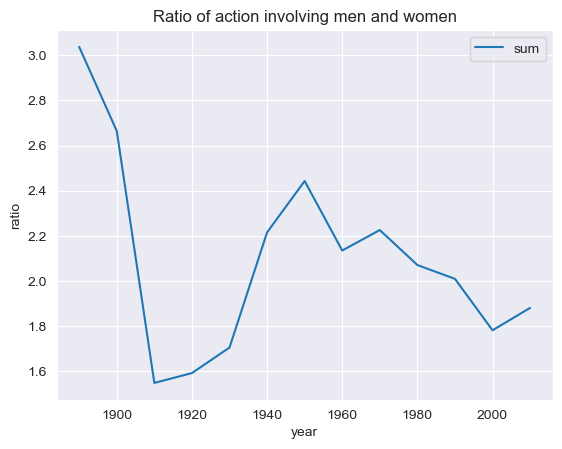

In [140]:
((res['number of actions on men'] + res['number of actions by men']) / (res['number of actions on women'] + res['number of actions by women'])).plot()
plt.title('Ratio of action involving men and women')
plt.xlabel('year')
plt.ylabel('ratio');

men tend to be more involved in actions than women

meets, gives,
kill, kills, shoot,
marry, loves,
save

In [89]:
actions_by = ['actions by men', 'actions by women']
actions_on = ['actions on men', 'actions on women']

In [111]:
def importance_word(x, word):
    return 0 if len(x) == 0 else x.count(word) / len(x)

In [118]:
def plot_word_evolution(word, features):
    res = movie_metadata_nlp[features].applymap(lambda x : importance_word(x, word))
    res = movie_metadata_nlp[['decade_released']].merge(res, on='wikipedia_movie_id')
    res = res.groupby('decade_released').agg(['mean', bootstrap_ci])
    res = res.dropna()
    res = res.reset_index()
    res.columns = [' '.join(col).strip() for col in res.columns.values]

    for action in features:
        low_ci  = res[action + ' bootstrap_ci'].apply(lambda ci : ci[0])
        high_ci = res[action + ' bootstrap_ci'].apply(lambda ci : ci[1])

        plt.fill_between(res.decade_released, low_ci, high_ci, alpha = 0.4)
        plt.plot(res.decade_released, res[action + ' mean'], label = action)

    plt.legend()
    plt.title('evolution of the word "' + word + '" over the years')
    plt.xlabel('year')
    plt.ylabel('word importance')

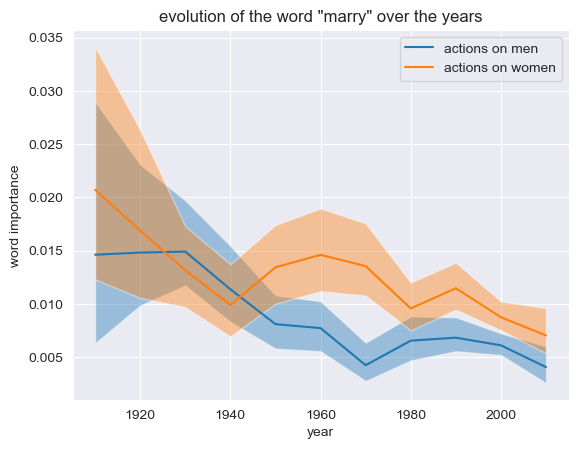

In [126]:
plot_word_evolution('marry', actions_on)

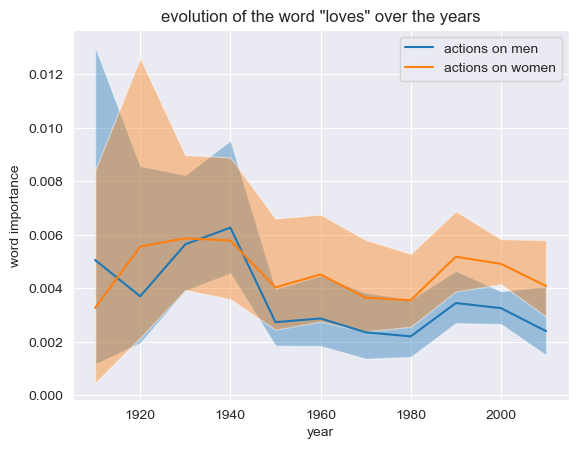

In [135]:
plot_word_evolution('loves', actions_on)

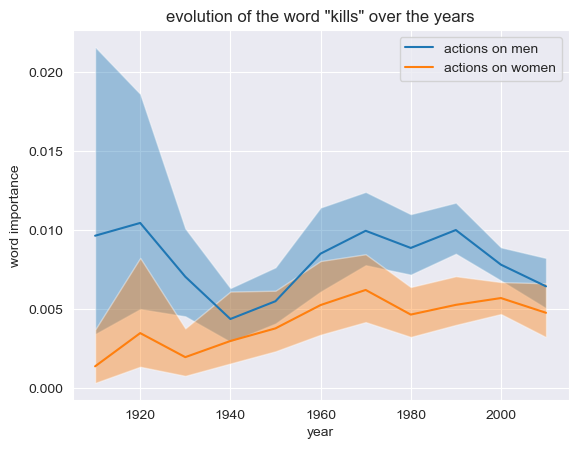

In [122]:
plot_word_evolution('kills', actions_on)

In [144]:
res = movie_metadata_nlp[['decade_released'] + nlp_number_descriptions].agg([np.sum, bootstrap_ci])

In [145]:
res

,decade_released,number of actions by men,number of actions by women,number of actions on men,number of actions on women,number of descriptions of men,number of descriptions of women
sum,78347540,1001645,493148,325829,190159,51090,34613
bootstrap_ci,"(1978.8346314099929, 1979.340910245135)","(24.953565898387318, 25.708354133632053)","(12.222360476368841, 12.727293517674289)","(8.107195246955524, 8.366169814060198)","(4.714735553625947, 4.898724911642491)","(1.2607897501803262, 1.3156088767822127)","(0.8530199513397927, 0.894268279696031)"


### E. Do the mean age of the actors, male and female, evolves over the years? (with the cliché in mind that +40-year-old actresses are “outdated”)

In [62]:
def get_character_df(columns : list[str]) :
    df = character_metadata.copy().dropna() 
    df['year'] = pd.DatetimeIndex(df['movie_release_date']).year.astype('int')
    df['actor_year'] = pd.DatetimeIndex(df['actor_birth_date']).year.astype('int')

    return df[columns]

In [63]:
def group_year_gender(columns : list[str]) :
    df = get_character_df(['actor_gender','actor_age', 'year'])
    df = df.groupby(['year', 'actor_gender']).mean()
    df = df.reset_index()

    return df

In [64]:
def plot_grouped_age(df : pd.DataFrame, y : str, title : str) :
    men = df.loc[df['actor_gender'] == 'M'].rename(columns={'actor_age' : 'men age'})
    women = df.loc[df['actor_gender'] == 'F'].rename(columns={'actor_age' : 'women age', 'life percentage' : 'women percentage'})
    
    if y == 'percentage' :
        men = men.rename(columns={'life percentage' : 'men percentage'})
        women = women.rename(columns={'life percentage' : 'women percentage'})
        
    ax = men.plot(x='year', y="men " + y, title=title)
    women.plot.line(x='year', y="women " + y, ax=ax) ;

In [65]:
# get life expectancy dataset of countries from https://data.worldbank.org/indicator/SP.DYN.LE00.IN?name_desc=false
# do a mean between all countries, this not perfect but easy

life_expectancy = life_expectancy_df.reset_index().rename(columns={'index' : 'name'})\
    .drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
life_expectancy = life_expectancy.drop(life_expectancy.columns[[0,1,-1]], axis=1).mean()

/var/folders/zg/jtqmvsps2tv_1fbgs_k5vfkw0000gp/T/ipykernel_62782/433162739.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  life_expectancy = life_expectancy.drop(life_expectancy.columns[[0,1,-1]], axis=1).mean()


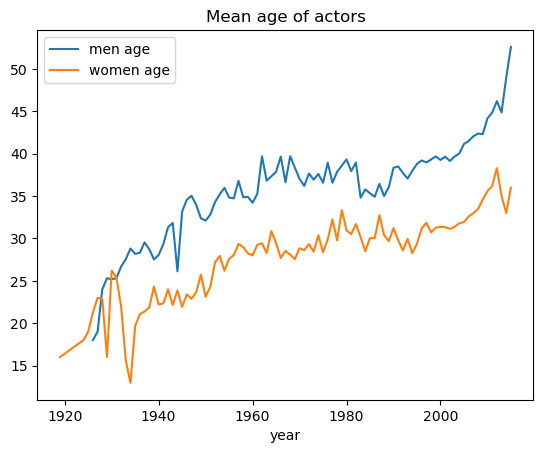

In [323]:
ages_grouped = group_year_gender(['actor_gender','actor_age', 'year'])
plot_grouped_age(ages_grouped,"age" , "Mean age of actors")

We can see that male actors are older in average. The average age of an actor increases in time but we keep a constant difference between male and females.

Let's not consider the absolute age of actors now, but instead the percentage of the life expectancy.

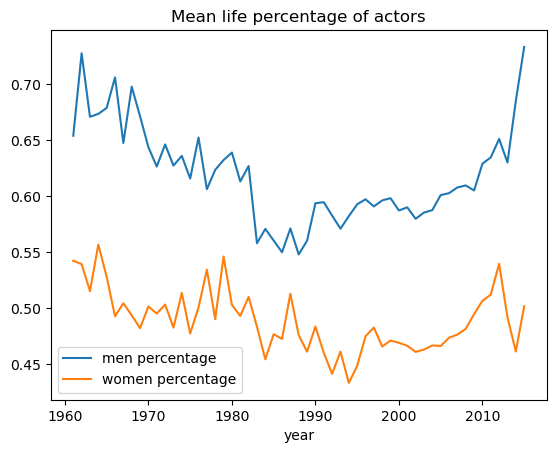

In [324]:
percentage_grouped = group_year_gender(['actor_gender','actor_age', 'year'])
percentage_grouped = percentage_grouped.loc[percentage_grouped['year'] >= 1961]

percentage_grouped['life expectancy'] = percentage_grouped['year'].apply(lambda e : life_expectancy[str(e)])
percentage_grouped['life percentage'] = percentage_grouped['actor_age'] / percentage_grouped['life expectancy']

plot_grouped_age(percentage_grouped,'percentage' , "Mean life percentage of actors")


We can see here that actors age relatively decreases slightly until 2000 then reincreases.

### F. Can we built the perfect archetypes of the male and female actor (age, height, ethnicity) over time?